# Exploratie van de inschrijvingen

In [1]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

from shapely.geometry import Point

c:\anaconda\envs\geo\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
pd.options.display.max_columns = 100

## Processing van de data

**Data inlezen**

In [4]:
data = pd.read_csv("curieuzeneuzen.csv", sep=",")

In [5]:
data['geometry'] = data.apply(lambda x: Point(x['Lon'], x['Lat']), axis=1)

In [6]:
data = geopandas.GeoDataFrame(data)

Coordinaten referentiesysteem naar UTM:

In [7]:
data.crs = {'init': 'epsg:4326', 'no_defs': True}

In [8]:
data = data.to_crs(epsg=31370)

**OpenStreetMap straten**

In [9]:
streets = geopandas.read_file("layer_openstreetmap_streets.shp")

Type van aangrenzende straat:

In [12]:
def closest_road(point, streets):
    """Distance to the nearest road [m] (OpenStreetMap)"""
    dist = streets.distance(point)
    return pd.Series([dist.min(), dist.idxmin()], index=['d_closest', 'closest'])

In [13]:
data[['d_closest', 'closest']] = data.geometry.apply(lambda x: closest_road(x, streets))

In [14]:
data['closest_type'] = data['closest'].replace(streets['highway'])

In [15]:
data['closest_type'].value_counts()

residential      2296
tertiary          215
secondary          99
pedestrian         59
living_street      45
primary            43
motorway           11
dtype: int64

**Traffic intensity**

In [16]:
traffic = geopandas.read_file("layer_trafficantwerp.shp")

In [17]:
def trafnear(point, traffic):
    """
    Traffic intensity on the nearest road [Veh day$^{-1}$]

    """
    closest_street = traffic.loc[traffic.distance(point).idxmin()].geometry
    closest_point = closest_street.interpolate(closest_street.project(point))
    closest_streets = traffic[traffic.geometry.intersects(closest_point.buffer(20))]
    return closest_streets['Q_TOTAL'].max()

In [18]:
data['trafnear'] = data.geometry.apply(lambda x: trafnear(x, traffic))

Afstand tot elkaar:

In [19]:
def afstand_tot_dichtsbijzijnde_locatie(point, data):
    d = data.distance(point)
    return d[d>0].min()

In [20]:
data['d_dicht'] = data.geometry.apply(lambda x: afstand_tot_dichtsbijzijnde_locatie(x, data))

Exporteer als shapefile:

In [23]:
data.loc[data['d_dicht'] > 10000, 'd_dicht'] = 10000

In [24]:
data.to_file("data.shp")

Exporteer als csv:

In [80]:
(temp['d_dicht'] < 50).sum()

1362

In [25]:
data[['Id', 'Email', 'closest_type', 'trafnear', 'd_dicht']].to_csv("curieuzeneuzen_extra.csv", index=False)

In [29]:
(data['d_dicht'] < 30).sum()

961

In [40]:
temp = data[data['Type']=='h']

In [44]:
temp = temp[(temp['Floor']>0) & (temp['Floor']< 10)]

In [46]:
temp = temp[temp['Postal'] != 2070]

In [58]:
temp = temp[temp['Postal'] != 2050]

In [59]:
len(temp)

2433

In [60]:
len(temp[(temp['d_dicht'] < 30)])

886

In [61]:
ids = []

for i in temp[(temp['d_dicht'] < 30)].index:
    d = temp.distance(temp.loc[i].geometry)
    d = temp[(d<30)]
    try:
        ids.append(d.iloc[0,0])
    except:
        pass

In [63]:
close_ids = np.unique(ids)

In [64]:
len(close_ids)

430

In [65]:
len(ids)

886

In [67]:
', '.join(close_ids.astype(str).tolist())

'4, 5, 11, 15, 17, 19, 20, 22, 29, 31, 36, 40, 44, 46, 47, 52, 54, 56, 58, 60, 61, 64, 66, 67, 72, 76, 77, 82, 83, 91, 92, 100, 102, 104, 107, 110, 111, 112, 115, 117, 119, 121, 125, 126, 139, 142, 144, 149, 150, 153, 156, 157, 160, 163, 169, 170, 172, 177, 180, 189, 193, 194, 195, 198, 199, 201, 202, 204, 205, 206, 209, 212, 218, 221, 223, 227, 228, 233, 237, 241, 243, 244, 245, 246, 247, 248, 249, 255, 262, 264, 265, 266, 269, 270, 272, 274, 277, 285, 286, 289, 290, 292, 302, 307, 315, 316, 321, 324, 327, 329, 330, 332, 335, 337, 339, 340, 342, 344, 346, 352, 356, 364, 365, 367, 370, 372, 378, 385, 390, 394, 396, 404, 416, 419, 421, 422, 427, 431, 432, 433, 437, 438, 443, 444, 451, 452, 456, 459, 460, 463, 468, 474, 475, 477, 480, 481, 482, 492, 496, 497, 500, 504, 506, 507, 510, 513, 515, 523, 533, 535, 537, 540, 546, 549, 553, 554, 561, 562, 566, 567, 568, 569, 570, 572, 580, 588, 591, 597, 599, 615, 617, 623, 625, 627, 631, 634, 636, 637, 639, 645, 650, 652, 653, 676, 683, 687, 69

In [ ]:
close_ids_leaveout = 

In [78]:
list(set(temp.loc[(temp['d_dicht'] < 30), 'Id'].tolist()) - set(close_ids))

[2049,
 2050,
 2051,
 2061,
 2066,
 2068,
 2069,
 2070,
 2074,
 2075,
 2076,
 2077,
 2078,
 2084,
 2086,
 2089,
 2091,
 2096,
 2100,
 2103,
 2111,
 2113,
 2115,
 2125,
 2133,
 2137,
 2138,
 2139,
 2141,
 2145,
 2147,
 2159,
 2160,
 2167,
 2168,
 2174,
 2175,
 2176,
 132,
 2182,
 2184,
 2185,
 2189,
 148,
 2196,
 2197,
 2199,
 2205,
 158,
 2207,
 2210,
 2216,
 2218,
 2220,
 2221,
 2224,
 178,
 2226,
 2227,
 2228,
 2236,
 190,
 2239,
 196,
 197,
 2252,
 2254,
 2267,
 2272,
 2274,
 2280,
 2281,
 2282,
 2283,
 2286,
 2289,
 2298,
 2299,
 2304,
 2313,
 2316,
 2323,
 278,
 2327,
 2344,
 2345,
 312,
 2363,
 2368,
 2369,
 323,
 2372,
 2373,
 2380,
 2381,
 2387,
 345,
 2395,
 2402,
 2404,
 357,
 2405,
 2407,
 2417,
 2418,
 2433,
 2436,
 402,
 2453,
 2458,
 2460,
 2463,
 2466,
 420,
 2470,
 2473,
 2474,
 2476,
 440,
 2493,
 2499,
 2500,
 461,
 2512,
 2514,
 472,
 2525,
 2528,
 2529,
 2534,
 2537,
 2538,
 2546,
 499,
 2550,
 2552,
 505,
 2558,
 2560,
 2564,
 2567,
 2570,
 2572,
 2573,
 526,
 2580

In [38]:
data[data[['Lat', 'Lon']].duplicated() | data[['Lat', 'Lon']].duplicated(take_last=True)].sort(['Lat'])

,Id,FirstName,LastName,Street,Nr,Bus,Postal,City,Email,Phone,StreetDistance,Height,Floor,Comment,CollectDay,Selected,EmailVerified,EmailVerifiedDate,InternComment,Contacted,WarrantPayed,WarrantReturned,IdLonLat,Registerdate,Lon,Lat,StreetSide,Type,geometry,d_closest,closest,closest_type,trafnear,d_dicht
2372,2375,Guido,De Cat,Rosalialaan,2,NaN,2265,Edegem,guidopetravincent@telenet.be,0497473110,NaN,NaN,1,NaN,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.424414,51.154504,1,h,POINT (153894.0588841047 204943.0191844413),882.151738,1944,residential,5536.39320,105.209956
910,913,Wim,Waroquier,Rosalalaan,39,NaN,2650,Edegem,wim@finebek.net,0474676170,NaN,NaN,1,NaN,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.424414,51.154504,1,h,POINT (153894.0588841047 204943.0191844413),882.151738,1944,residential,5536.39320,105.209956
989,992,Nuchelmans,Lucie,Antwerpsestraat,122,NaN,2640,Mortsel,Lucienuchelmans@hotmail.com,0486874776,NaN,NaN,1,NaN,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.444001,51.173673,1,h,POINT (155262.2891643118 207076.889033678),9.990131,7435,primary,1089.16455,159.365861
1190,1193,Joeri,Bollaert,Antwerpsestraat,122,NaN,2640,Mortsel,joeribollaert@hotmail.com,0486 524776,NaN,NaN,1,NaN,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.444001,51.173673,1,h,POINT (155262.2891643118 207076.889033678),9.990131,7435,primary,1089.16455,159.365861
832,835,Helmut,Feyen,Kruishofstraat,144,43,2020,Antwerpen,helmoet820@yahoo.be,NaN,NaN,NaN,11,11de verdiep aan de A12 - Boomsesteenweg,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.392873,51.182311,1,h,POINT (151686.2207007214 208035.3759153709),0.226487,6190,residential,457.00000,84.522572
41,43,Wim,Kerremans,Kruishofstraat,144,118,2020,Antwerpen,redbyte@wimkerremans.be,NaN,NaN,NaN,13,13,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.392873,51.182311,1,h,POINT (151686.2207007214 208035.3759153709),0.226487,6190,residential,457.00000,84.522572
477,479,Philippe,Hens,boomsesteenweg,429,4,2020,Antwerpen,philippehens@gmail.com,0472872372,NaN,NaN,4,4,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.389324,51.183895,1,h,POINT (151438.0694142171 208211.5460102903),1.690168,3594,residential,61.00000,108.967921
991,994,Verreydt,Charlotte,Boomsesteenweg,429,NaN,2020,Antwerpen,charlotteverreydt@gmail.com,NaN,NaN,NaN,1,NaN,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.389324,51.183895,1,h,POINT (151438.0694142171 208211.5460102903),1.690168,3594,residential,61.00000,108.967921
2618,2622,Mustafa,Nafia,Hazelarenstraat,19,1,2020,Antwerpen,mustafa.nafia@live.be,0486233454,NaN,NaN,1,NaN,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.393882,51.185338,1,h,POINT (151756.7118305608 208372.1630536495),4.837174,3036,residential,61.00000,48.658469
1398,1401,Christine,Van Look,Hazelarenstraat,19,NaN,2020,Antwerpen,Vanlook_christine@yahoo.fr,0486233454,NaN,NaN,1,NaN,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.393882,51.185338,1,h,POINT (151756.7118305608 208372.1630536495),4.837174,3036,residential,61.00000,48.658469


<IPython.core.display.Javascript object>


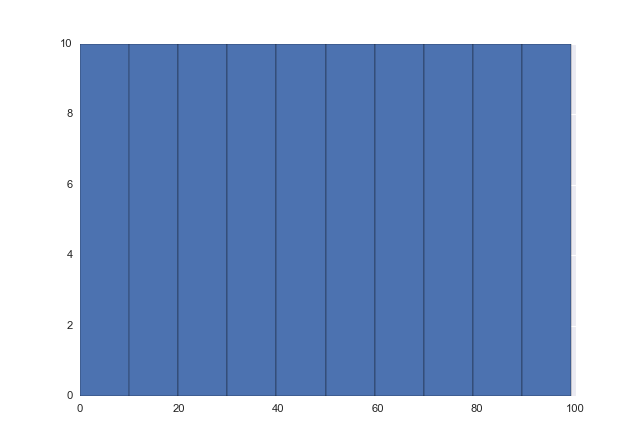

(array([ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.]),
 array([  0. ,   9.9,  19.8,  29.7,  39.6,  49.5,  59.4,  69.3,  79.2,
         89.1,  99. ]),
 <a list of 10 Patch objects>)

In [10]:
plt.hist(np.arange(100))

<IPython.core.display.Javascript object>


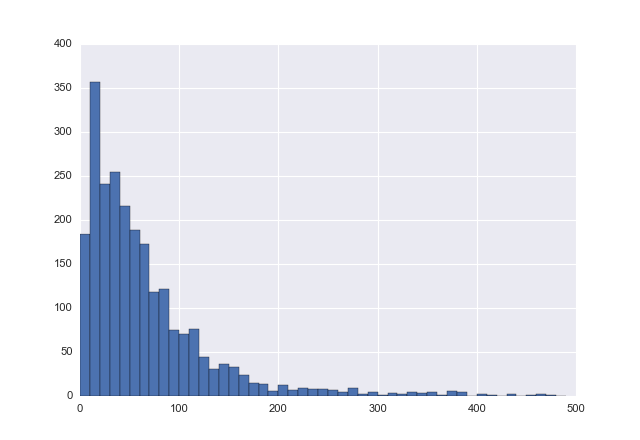

(array([ 184.,  357.,  241.,  254.,  216.,  189.,  173.,  118.,  122.,
          75.,   71.,   76.,   44.,   31.,   36.,   33.,   24.,   15.,
          14.,    6.,   12.,    7.,    9.,    8.,    8.,    7.,    5.,
           9.,    2.,    4.,    1.,    3.,    2.,    5.,    3.,    4.,
           1.,    6.,    5.,    0.,    2.,    1.,    0.,    2.,    0.,
           1.,    2.,    1.,    0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490]),
 <a list of 49 Patch objects>)

In [15]:
plt.figure()
plt.hist((data['d_dicht'][data['d_dicht'] < 500]).values, bins=np.arange(0,500,10))

In [20]:
data[['email', 'd_dicht']].to_csv("extra_afstand_dichtste.csv", index=False)

## Meetlocaties op een kaart

<IPython.core.display.Javascript object>


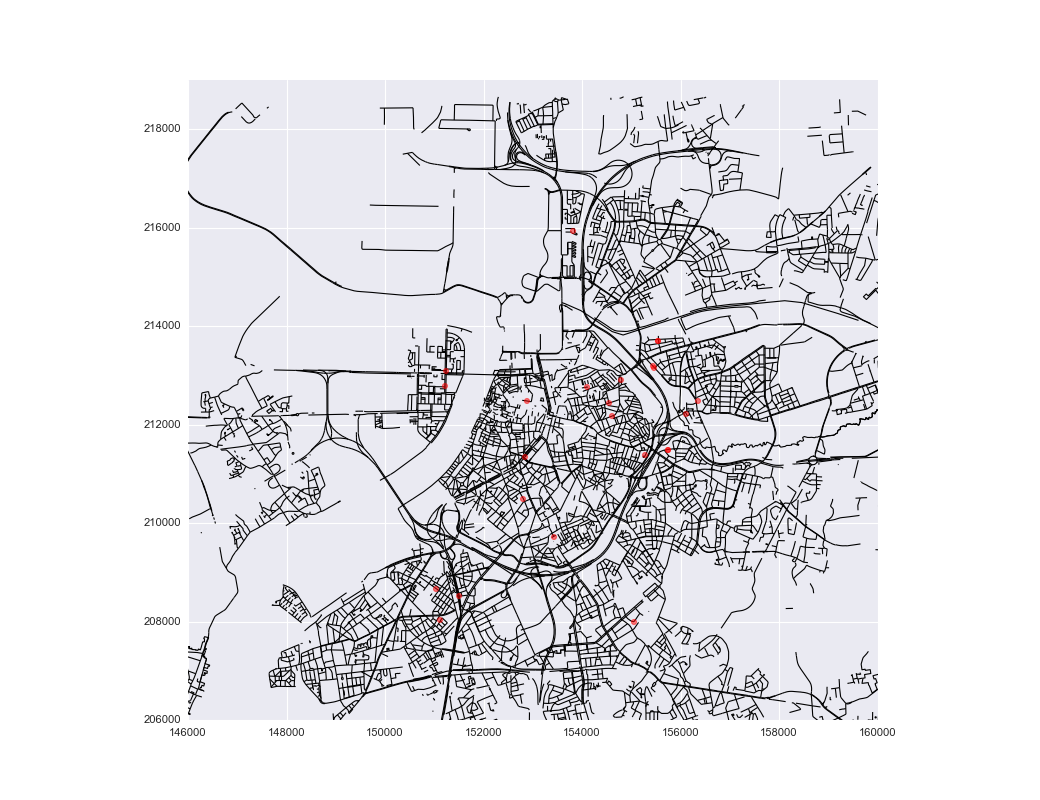

[(146000, 160000), (206000, 219000)]

In [56]:
ax = streets.plot(color='k', figsize=(13,10))
data[data['gebouw_type']=='School'].plot(ax=ax, color='r', zorder=10, alpha=0.5)
ax.set(xlim=(146000, 160000), ylim=(206000, 219000))

<IPython.core.display.Javascript object>


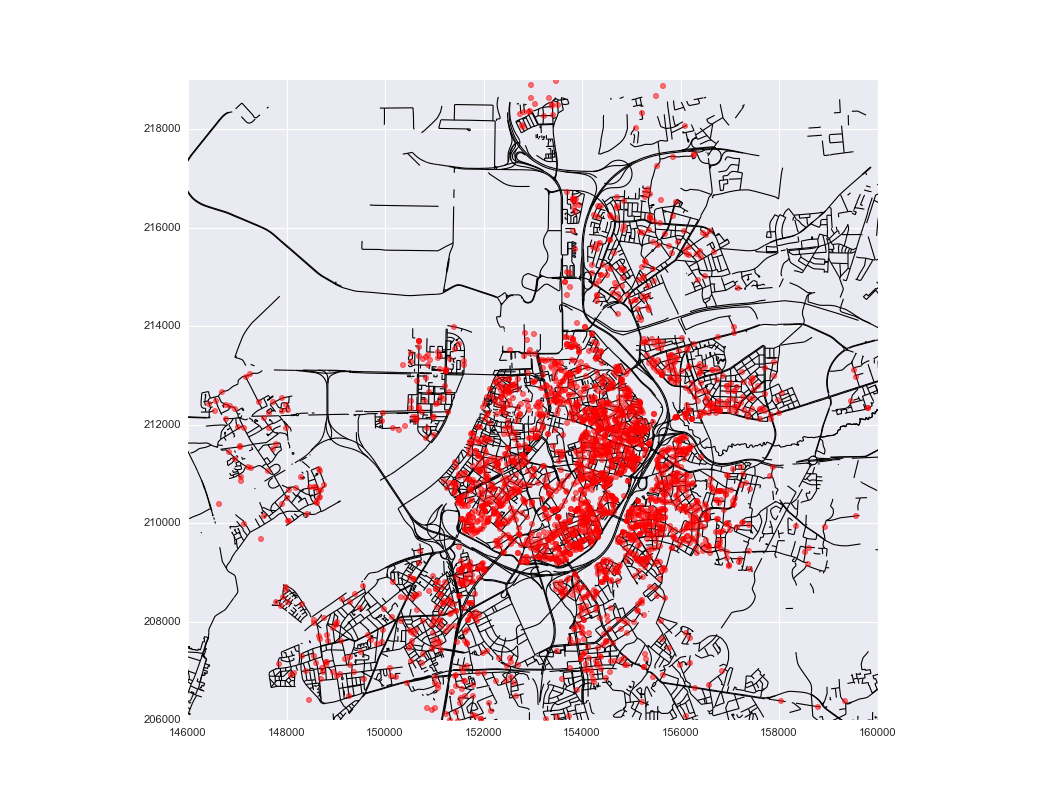

[(206000, 219000), (146000, 160000)]

In [10]:
ax = streets.plot(color='k', figsize=(13,10))
data.plot(ax=ax, color='r', zorder=10, alpha=0.5)
ax.set(xlim=(146000, 160000), ylim=(206000, 219000))

Er zijn een aantal locaties die zeer ver van Antwerpen liggen:

<IPython.core.display.Javascript object>


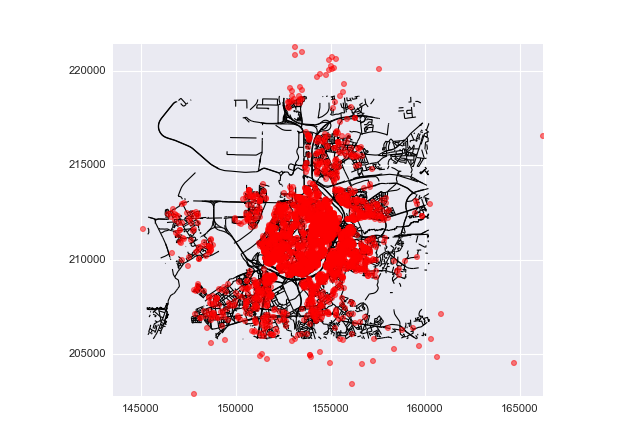

In [11]:
ax = streets.plot(color='k')
data.plot(ax=ax, color='r', zorder=10, alpha=0.5)

In [11]:
data[data['Lon'] > 4.6]

,Id,FirstName,LastName,Street,Nr,Bus,Postal,City,Email,Phone,StreetDistance,Height,Floor,Comment,CollectDay,Selected,EmailVerified,EmailVerifiedDate,InternComment,Contacted,WarrantPayed,WarrantReturned,IdLonLat,Registerdate,Lon,Lat,StreetSide,Type,geometry
1124,1127,Glen,Joris,Liersebaan,40,NaN,2980,Halle-Zoersel,joris.glen@gmail.com,0476504148,NaN,NaN,1,NaN,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.630678,51.256510,1,h,POINT (168285.041004455 216322.490100109)
1742,1745,Bieke,Schiltz,Boskant,4,NaN,2970,Schilde,bieke.schiltz@telenet.be,NaN,NaN,NaN,1,landhuisje: gelijkvloers en eerste verdieping,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.601182,51.258490,0,h,POINT (166225.2117468309 216535.9581260933)
1769,1772,Rijmen,Dieter,Sporkbos,7,NaN,2280,Grobbendonk,dieter.rijmen@telenet.be,NaN,NaN,NaN,1,NaN,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.728170,51.194100,0,h,POINT (175124.7645386102 209407.7398867477)
2141,2144,Rita,Meeusen,Smekenstraat,6,NaN,2390,Malle,vanaertmeeusen@gmail.com,0478284394,NaN,NaN,1,NaN,1,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,4.737705,51.304526,1,h,POINT (175730.1569788206 221696.4128300622)


In [48]:
pd.options.display.max_columns=100

In [52]:
data['v_bord'].value_counts()

True     2289
False     151
dtype: int64

In [55]:
data['email'].tolist()

['Johan.terryn@telenet.be',
 'Ingrid.Henrard@googlemail.com',
 'kurtvanmerode@skynet.be',
 'catherinejoos@yahoo.com',
 'linusderoo@gmail.com',
 'jan.schonk@gmail.com',
 'bart.demey.55@gmail.com',
 'burgemeester@antwerpen.be',
 'nathalie.leblans@gmail.com',
 'dietwinvdw@hotmail.com',
 'anton.vanlaer@gmail.com',
 'joriscallaerts@gmail.com',
 'Erik.helderweert@gmail.com',
 'stefan.caruso@persgroep.be',
 'dieter.de.moitie@gmail.com',
 'Michael.segers@gmail.com',
 'filip.lenaerts@gmail.com',
 'ellen.vansteenberge@gmail.com',
 'windehoeyberghs@hotmail.com',
 'annelies.boerema@uantwerpen.be',
 'jandecan@yahoo.com',
 'rappe.ward@gmail.com',
 'quintenvervecken@hotmail.com',
 'jaspersmet@gmail.com',
 'marliesherlinde@hotmail.com',
 'marieke.denbrinker@gmail.com',
 'nachavansteen@hotmail.com',
 'ludo.aerts5@telenet.be',
 'clennkustermans@gmail.com',
 'yoshicraeye@gmail.com',
 'marcel.kina@skynet.be',
 'jesse.govaerts@gmail.com',
 'eddy.uytdewilligen@telenet.be',
 'tom.vandenborne@telenet.be',
 'j

## Type gebouwen?

In [50]:
data['gebouw_type'].dropna().value_counts()

Woning               2333
Bedrijf                45
School                 24
Verenigingslokaal      11
dtype: int64

<IPython.core.display.Javascript object>


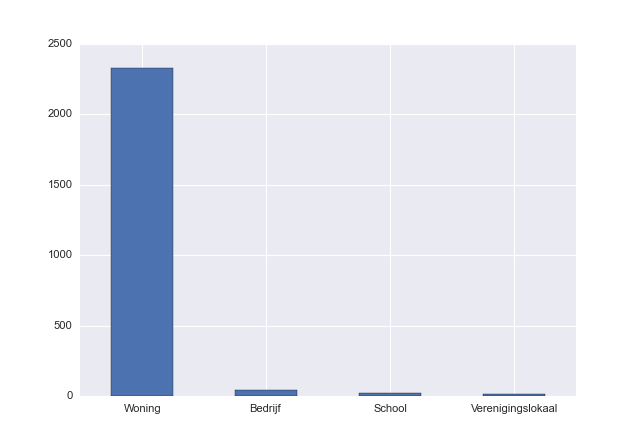

In [15]:
fig, ax = plt.subplots()
data['gebouw_type'].dropna().value_counts().plot(kind='bar', ax=ax, rot=0)

In [49]:
data[data['gebouw_type']=='School']

,wp_form_id,post_id,latitude,longitude,voornaam,naam,email,tel,straat,nummer,bus,postcode,plaats,gebouw_type,in_meetgebied,raam_straat,v_bord,verdiep_1,verdiep_ander,nieuwsbrief,geometry,trafnear
350,400,878,51.219885,4.456297,Hans,Haagdorens,hans.haagdorens@gmail.com,0494047404,Hertstraat,7,NaN,2100,Antwerpen,School,True,True,True,True,NaN,False,POINT (156116.104471536 212219.0002414687),61.0
427,477,955,51.226132,4.437429,Inge,Boehnke,ingeboehnke@hotmail.com,0485037424,Maatsstraat,24,NaN,2060,Antwerpen,School,True,True,True,True,NaN,False,POINT (154797.2107948562 212912.5982709397),61.0
715,767,1246,51.233133,4.448204,Basisschool,De Bever,Debever@so.antwerpen.be,0485747363,Albert Bevernagelei,65,NaN,2100,Deurne,School,True,True,True,True,NaN,False,POINT (155549.0477184367 213692.2523029959),488.0
721,773,1252,51.228612,4.446559,Cristina,Ramos,crechendo1@telenet.be,0478474202,Ten Eekhovelei,305,NaN,2100,Deurne,School,True,True,True,True,NaN,True,POINT (155434.6743852222 213189.2344649471),463.0
741,793,1272,51.228315,4.446978,Nathalie,Van Wijnngaert,kdv.triangel@telenet.be,NaN,Ten Eekhovelei,289,NaN,2100,Deurne,School,True,True,True,True,NaN,True,POINT (155464.0061858475 213156.1449235408),463.0
878,931,1409,51.181933,4.440895,Stedelijke basisschool,Fruithof,Petra.avermaete@so.antwerpen.be,0473856099,Flor alpaertsstraat,45,NaN,2600,Berchem,School,True,True,True,True,NaN,False,POINT (155044.1108569502 207995.5970317787),61.0
883,936,1414,51.253351,4.423261,Maya,Verhoeven,maya.verhoeven@so.antwerpen.be,0485362901,Columbiastraat,6,NaN,2030,Antwerpen,School,True,True,True,True,NaN,False,POINT (153805.1928116487 215940.1086483588),196.0
886,939,1417,51.188016,4.383496,PiusX instituut - Gert,Renders,Gert.renders@piustien.net,0476 83 09 83,Abdijstraat,128,NaN,2020,Antwerpen,School,True,True,True,True,NaN,True,POINT (151030.4626563104 208669.9307353683),284.0
926,982,1457,51.227823,4.386533,Nathalie,Verelst,mevrouwverelst@gmail.com,0486536089,Gloriantlaan,75,NaN,2050,Linkeroever,School,True,True,True,True,NaN,False,POINT (151241.6490527668 213098.6493996512),184.0
1011,1068,1543,51.233133,4.448204,Odile,Sterkens,sterkensodile@hotmail.com,0495160198,Albert Bevernagelei,65,65,2100,Deurne,School,True,True,True,True,NaN,True,POINT (155549.0477184367 213692.2523029959),488.0


## Op de eerste verdieping of niet?

<IPython.core.display.Javascript object>


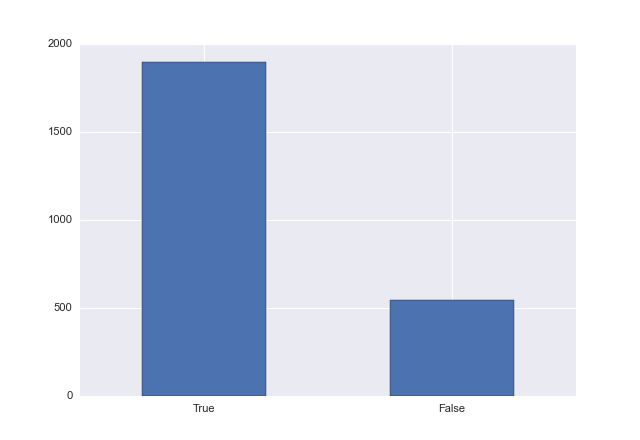

In [16]:
plt.figure()
data['verdiep_1'].value_counts().plot(kind='bar', rot=0)

## En indien niet, welke verdieping dan wel?

In [20]:
m = {'gelijkvloers': ['gelijkvloers'],
     '2de': ['2', 'tweede verdieping', '2e verdieping', '2de verdieping', '2e', 'tweede', '2de verdiep', 'op de tweede verdieping'],
     '3de': ['3', 'derde verdieping', 'derde', '3e', '3de verdieping', 'op de 3de verdieping', '3de ved.', '3e verdieping'],
     '4de': ['4', '4de verdieping', '4e', 'vierde', 'vierde verdieping'],
     '5de': ['5', 'verdieping 5', '5e verdieping', '5de verdieping'],
     '6de': ['6', '6de verdieping', '6e verdieping', '6 de'],
     '7de': ['7', '7de verdieping'],
     '8ste': ['8', '8ste verdieping']}

m = {'gelijkvloers': ['gelijkvloers', 'gelijkvloerse verdieping', 'gelijkvloerse', 'glvl', 'gelijksvloer', 'glv'],
     '2de': ['2', 'tweede', 'tweede verdieping', '2de verdieping', '2e', '2de verdiep', '2e verdieping', '2e verdiep', 'twee', '2 verdieping appartement', 'op de tweede verdieping'],
     '3de': ['3', 'derde', 'derde verdieping', '3de verdieping', '3e', '3de ved.', 'De derde', '3e verdieping', '3rde', '3° VERDIEPING', 'op de 3de verdieping', '3e verdiep'],
     '4de': ['4', 'vierde', 'vierde verdieping', '4de verdieping', '4e', '4e verdieping'],
     '5de': ['5', 'vijfde', 'vijfde verdieping', '5de verdieping', '5e', '5 de', 'verdieping 5', '5e verdieping'],
     '6de': ['6', 'zesde', 'zesde verdieping', '6de verdieping', '6e', '6e verdieping', '6 de', '6de verdiep'],
     '7de': ['7', 'zevende', 'zevende verdieping', '7de verdieping', '7e', '7 de', '7 de verdieping', '7de verdiep'],
     '8ste': ['8', 'achtste', 'achtste verdieping', '8ste verdieping', '8e', '8ste verdieping'],
     '>8': ['9', '10', '11', '12', '13', '14', '15', '11de verdieping', '11e', '11de', '12de verdieping', '12e', '12de', '12e verdieping', '12 de verdieping', '13e verdieping', '13e', '13de', '14e verdieping', '14e', '14de', '14 de', '15e verdieping', '15e', '15de', '18e verdieping', '18e', '18de', '18de verdieping'] }

m2 = {val: key for key in m for val in m[key]}

In [21]:
verdiep = data['verdiep_ander'].dropna().astype(str).str.lower()

<IPython.core.display.Javascript object>


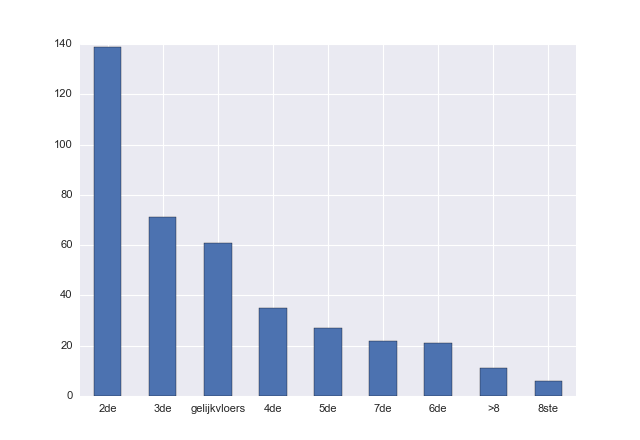

In [23]:
plt.figure()
verdiep.replace(m2).value_counts().head(9).plot(kind='bar', rot=0)

## In welk type straat liggen de meetlocaties?

Dit gebruikt de types zoals ze in OpenStreetMap zitten, onderaan staat ook een kaartje waarop is aangeduid welke straat welk type is (probleem is wel dat de kaart van OpenStreetMap niet helemaal volledig is).

<IPython.core.display.Javascript object>


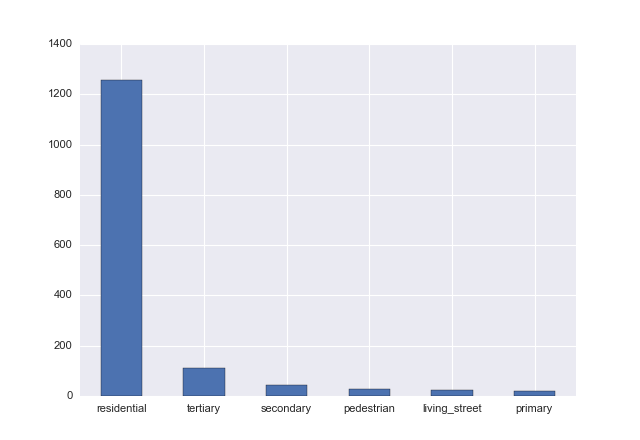

In [19]:
plt.figure()
data['closest_type'][data['d_closest'] < 15].value_counts().plot(kind='bar', rot=0)

<IPython.core.display.Javascript object>


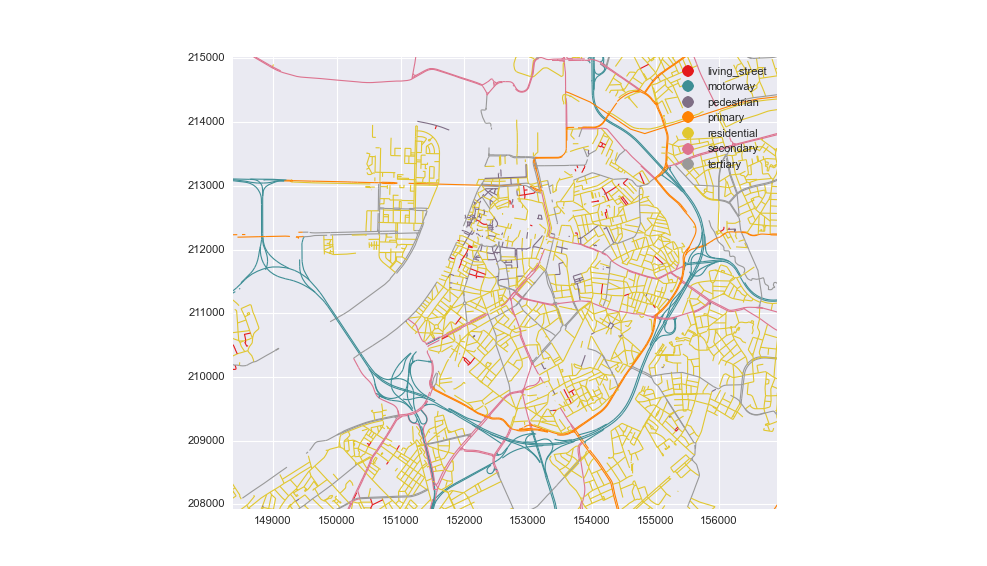

In [195]:
streets.plot(column='highway', legend=True, cmap='Set1', alpha=1)

## Verkeersintensiteit?

In [24]:
traffic = geopandas.read_file("layer_trafficantwerp.shp")

<IPython.core.display.Javascript object>


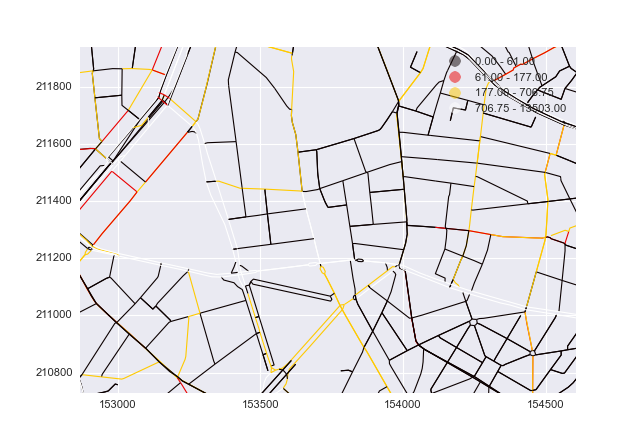

In [30]:
traffic.plot(column='Q_TOTAL', legend=True, scheme='quantiles', k=8, cmap='hot')

In [33]:
def trafnear(point, traffic):
    """
    Traffic intensity on the nearest road [Veh day$^{-1}$]

    """
    closest_street = traffic.loc[traffic.distance(point).idxmin()].geometry
    closest_point = closest_street.interpolate(closest_street.project(point))
    closest_streets = traffic[traffic.geometry.intersects(closest_point.buffer(20))]
    return closest_streets['Q_TOTAL'].max()

In [34]:
data['trafnear'] = data.geometry.apply(lambda x: trafnear(x, traffic))

<IPython.core.display.Javascript object>


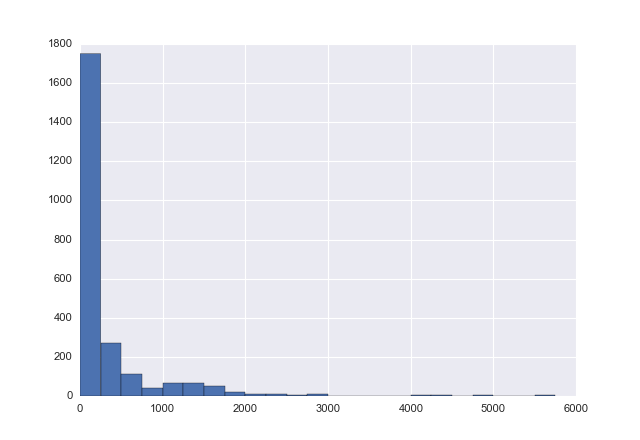

In [38]:
plt.figure()
data['trafnear'].hist(bins=np.arange(0, 6000, 250))

<IPython.core.display.Javascript object>


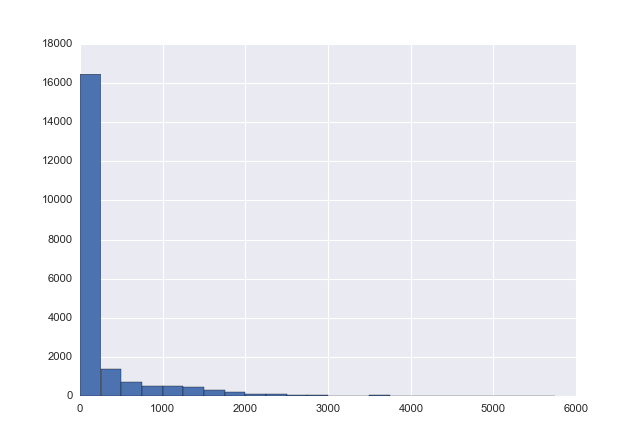

In [41]:
plt.figure()
traffic['Q_TOTAL'].hist(bins=np.arange(0, 6000, 250))

In [44]:
data[['wp_form_id', 'post_id', 'geometry', 'trafnear']].to_file("data.shp")